# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

<ipython-input-1-c9bf88156795>:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
import memento

In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'
data_path = '/data_volume/memento/pbmc/'

### Perform some basic filtering

In [30]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells', 'Megakaryocytes', 'Dendritic cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B', 'Mega', 'DC']))

In [31]:
def simplify_name(name):
    return name.split('.')[0]

In [35]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata.obs['ct'] = adata.obs.cell.apply(lambda x: label_converter[x])

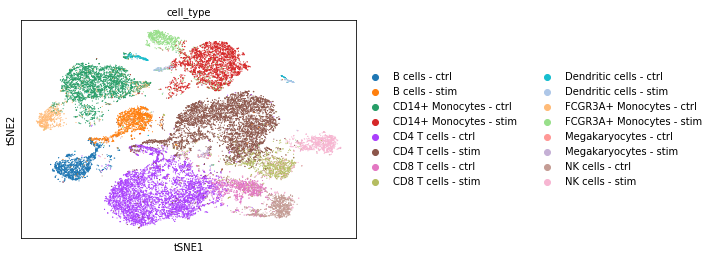

In [36]:
sc.pl.tsne(adata, color='cell_type')

In [37]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

### Setup memento

In [38]:
adata.obs['q'] = 0.07

In [39]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1, filter_mean_thresh=0.07)

Version 0.0.6


### WT cytokine variability

In [102]:
ctrl = adata[adata.obs.stim=='ctrl'].copy().copy()
ctrl.obs['group'] = 1
memento.create_groups(ctrl, label_columns=['ct', 'ind'])
memento.compute_1d_moments(ctrl, min_perc_group=.3)
# memento.ht_1d_moments(
#     wt_subset, 
#     formula_like='1',
#     treatment_col='Inter', 
#     num_boot=10000, 
#     verbose=1,
#     num_cpus=70,
#     resampling='permutation',
#     approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [103]:
m_df, v_df = memento.get_1d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
  m = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [104]:
cytokines = pd.read_csv('mart_export.txt')['Gene name'].tolist()
m_df['cytokine'] = m_df['gene'].isin(cytokines)
v_df['cytokine'] = v_df['gene'].isin(cytokines)
cytokines = v_df.query('cytokine').gene.tolist()

In [105]:
v_df_melt = v_df.melt(['gene', 'cytokine'], ['ct_cM', 'ct_Th', 'ct_DC', 'ct_NK', 'ct_Tc', 'ct_B', 'ct_Mega', 'ct_ncM'])
m_df_melt = m_df.melt(['gene', 'cytokine'], ['ct_cM', 'ct_Th', 'ct_DC', 'ct_NK', 'ct_Tc', 'ct_B', 'ct_Mega', 'ct_ncM'])

(-3.5, 4.0)

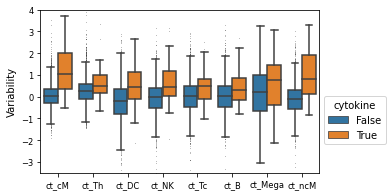

In [106]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='cytokine',data=v_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,0.5), title='cytokine'); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-3.5,4)

In [109]:
memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(cytokines,2)))
c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [134]:
cm_c_df = c_df[['gene_1', 'gene_2', 'ct_cM']]
cm_heatmap = cm_c_df.pivot(index='gene_1', columns='gene_2')['ct_cM'].fillna(0.0)
cm_heatmap = ((cm_heatmap + cm_heatmap.T)/2).fillna(0.0)

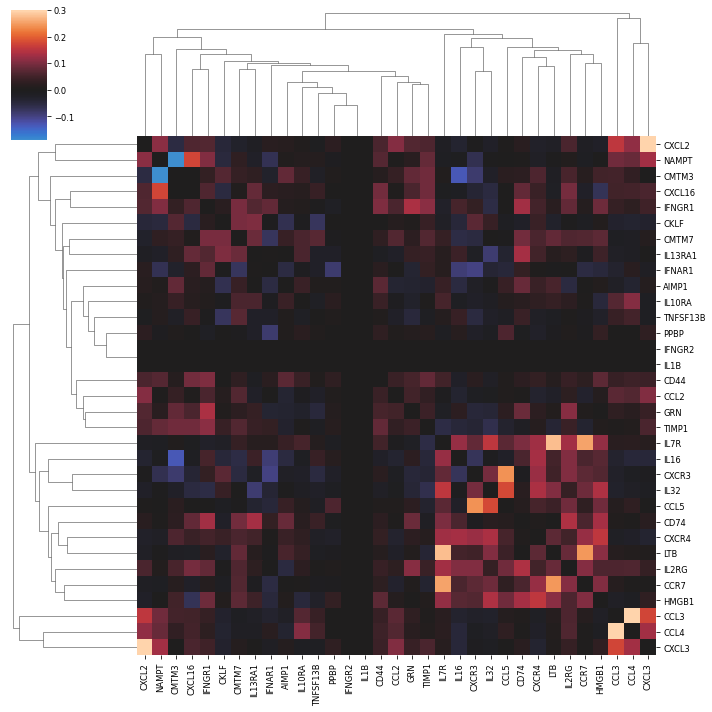

In [138]:
sns.clustermap(cm_heatmap, center=0, vmax=0.3)

In [ ]:
Index(['IL10RA', 'AES', 'SELL', 'EVL', 'GIMAP5', 'SEPT6', 'LEPROTL1', 'IL7R',
       'CCR7', 'GIMAP7', 'CLEC2D'],

### Identify IFNB ISGs

In [147]:
cM = adata[adata.obs.ct=='cM'].copy().copy()
memento.create_groups(cM, label_columns=['stim', 'ind'])
memento.compute_1d_moments(cM, min_perc_group=.3)
memento.ht_1d_moments(
    cM, 
    formula_like='1 + stim + ind',
    treatment_col='stim', 
    num_boot=10000, 
    verbose=1,
    num_cpus=92,
    resampling='permutation',
    approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    4.7s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    9.8s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   16.7s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   25.1s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   35.5s
[Parallel(n_jobs=92)]: Done 2697 out of 2697 | elapsed:   44.8s finished


In [168]:
cM_df = memento.get_1d_ht_result(cM)
cM_df['de_fdr'] = memento.util._fdrcorrect(cM_df['de_pval'])
ifnb_isg = cM_df.query('de_coef > 0.5 & de_fdr < 0.01').gene.tolist()

### Do the same thing for ISGs

In [248]:
m_df, v_df = memento.get_1d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
  m = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [249]:
m_df['cytokine'] = m_df['gene'].isin(cytokines)
v_df['cytokine'] = v_df['gene'].isin(cytokines)
m_df['ifnb_isg'] = m_df['gene'].isin(ifnb_isg)
v_df['ifnb_isg'] = v_df['gene'].isin(ifnb_isg)
ifnb_isg_ctrl = m_df.query('ifnb_isg').gene.tolist()

In [250]:
v_df_melt = v_df.melt(['gene', 'cytokine', 'ifnb_isg'], ['ct_cM', 'ct_Th', 'ct_DC', 'ct_NK', 'ct_Tc', 'ct_B', 'ct_Mega', 'ct_ncM'])
m_df_melt = m_df.melt(['gene', 'cytokine', 'ifnb_isg'], ['ct_cM', 'ct_Th', 'ct_DC', 'ct_NK', 'ct_Tc', 'ct_B', 'ct_Mega', 'ct_ncM'])

(-3.5, 4.0)

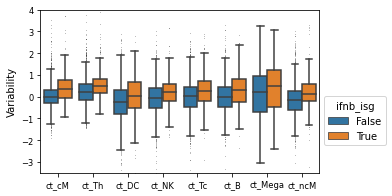

In [251]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='ifnb_isg',data=v_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,0.5), title='ifnb_isg'); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-3.5,4)

In [173]:
memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(ifnb_isg_ctrl,2)))
c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [174]:
cm_c_df = c_df[['gene_1', 'gene_2', 'ct_cM']]
cm_heatmap = cm_c_df.pivot(index='gene_1', columns='gene_2')['ct_cM'].fillna(0.0)
cm_heatmap = ((cm_heatmap + cm_heatmap.T)/2).fillna(0.0)

In [183]:
# fig, ax = plt.subplots()
cg = sns.clustermap(cm_heatmap, center=0, vmax=0.3, yticklabels=1); plt.close()
row_inds = cg.dendrogram_row.reordered_ind
col_inds = cg.dendrogram_col.reordered_ind

In [188]:
len(col_inds)

295

In [201]:
cm_heatmap.index[col_inds][x1:x2]

Index(['IL10RA', 'AES', 'SELL', 'EVL', 'GIMAP5', 'SEPT6', 'LEPROTL1', 'IL7R',
       'CCR7', 'GIMAP7', 'CLEC2D'],
      dtype='object')

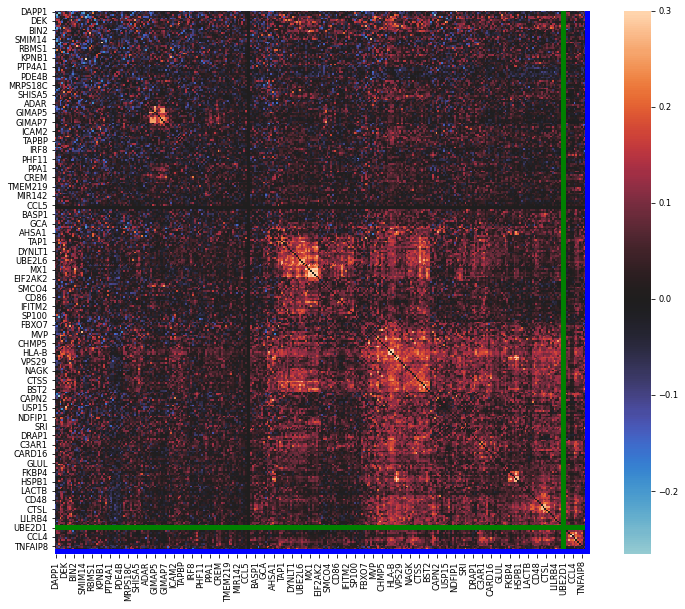

In [246]:
plt.figure(figsize=(12,10))
sns.heatmap(cm_heatmap.iloc[row_inds, col_inds], center=0, vmax=0.3)
x1 = 280
x2 = 293
plt.plot([x1, x1], [0, len(col_inds)], color='green', lw=5)
plt.plot([0, len(col_inds)], [x1, x1], color='green', lw=5)

plt.plot([x2, x2], [0, len(col_inds)], color='blue', lw=5)
plt.plot([0, len(col_inds)], [x2, x2], color='blue', lw=5)

In [247]:
for g in cm_heatmap.index[col_inds][x1:x2]:
    print(g)

UBE2D1
NINJ1
PIM3
WTAP
CCL3
CCL4
LYN
SOD2
PLEK
CD83
TNFAIP8
DNAJC15
SAMHD1


### Perform 1D hypothesis testing

In [35]:
cts = ['CD14+ Monocytes']

In [36]:
%%time
adata_dict = {}
for ct in cts:
    
#     if ct != 'FCGR3A+ Monocytes':
#         continue

    print('Processing:', ct)
    adata_dict[ct] = adata[adata.obs.cell == ct].copy().copy()
#     adata_dict[ct].obs['stim'] = np.random.choice(adata_dict[ct].obs['stim'], adata_dict[ct].shape[0])
    memento.create_groups(adata_dict[ct], label_columns=['ind','stim'])

    memento.compute_1d_moments(
        adata_dict[ct], 
        min_perc_group=0.7)
    
    print('Number of genes kept for {}: {}'.format(ct, adata_dict[ct].shape[1]))
    print('IFI6' in adata_dict[ct].var.index)
    memento.ht_1d_moments(
        adata_dict[ct], 
        formula_like='1 + stim',
        cov_column='stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14)

Processing: CD14+ Monocytes


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


Number of genes kept for CD14+ Monocytes: 1734
True


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    4.5s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:   16.5s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   34.4s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:  1.6min


CPU times: user 11 s, sys: 522 ms, total: 11.5 s
Wall time: 2min 20s


[Parallel(n_jobs=14)]: Done 1734 out of 1734 | elapsed:  2.3min finished


In [37]:
# Save the result
for ct in ['CD14+ Monocytes']:
    memento.prepare_to_save(adata_dict[ct])
    adata_dict[ct].write(data_path + 'result_1d/ifn/{}_20210321.h5ad'.format(label_converter[ct]))

... storing 'memento_group' as categorical


### Read the hypothesis test result

In [38]:
adata_dict = {}
for ct in ['CD14+ Monocytes']:
    adata_dict[ct] = sc.read(data_path + 'result_1d/ifn/{}_20210104.h5ad'.format(label_converter[ct]))

### Get a list of ISGF3 and IRF1 bound genes

In [39]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})


In [40]:
distances.query('gene == "ISG20"')

,gene,distance
11347,ISG20,0


In [41]:
def cut(x):
    
    if x < 1:
        return 'in TSS'
    else:
        return 'far'

In [43]:
ht_result_1d_dict = {}
for ct in ['CD14+ Monocytes']:
    ht_result_1d_dict[ct] = memento.get_1d_ht_result(adata_dict[ct])
    ht_result_1d_dict[ct]['de_fdr'] = memento.util._fdrcorrect(ht_result_1d_dict[ct]['de_pval'])
    ht_result_1d_dict[ct]['dv_fdr'] = memento.util._fdrcorrect(ht_result_1d_dict[ct]['dv_pval'])
    
    ht_result_1d_dict[ct] = ht_result_1d_dict[ct].merge(distances, on='gene', how='left')
    ht_result_1d_dict[ct]['ct'] = label_converter[ct]
    
    ht_result_1d_dict[ct] = ht_result_1d_dict[ct].query('distance > -1')

    ht_result_1d_dict[ct]['distance_bin'] = ht_result_1d_dict[ct]['distance'].apply(cut)
    
    ht_result_1d_dict[ct]['distance_bin'] = pd.Categorical(ht_result_1d_dict[ct]['distance_bin'], ['in TSS','far'])
    
    ht_result_1d_dict[ct] = ht_result_1d_dict[ct].sort_values('distance_bin')

ht_result_1d_all = pd.concat([df for ct, df in ht_result_1d_dict.items()])

In [44]:
ht_result_1d_dict['CD14+ Monocytes'].to_csv('cd14_1d_result.csv', index=False)

In [175]:
stats.mannwhitneyu(
    ht_result_1d_dict['CD14+ Monocytes'].query('de_coef > 0 & de_fdr < 0.05 & distance_bin == "in TSS"').dv_coef,
    ht_result_1d_dict['CD14+ Monocytes'].query('de_coef > 0 & de_fdr < 0.05 & distance_bin == "far"').dv_coef
)

MannwhitneyuResult(statistic=12034.0, pvalue=0.0012019013686918557)

In [176]:
stats.mannwhitneyu(
    ht_result_1d_dict['FCGR3A+ Monocytes'].query('de_coef > 0 & de_fdr < 0.05 & distance_bin == "in TSS"').dv_coef,
    ht_result_1d_dict['FCGR3A+ Monocytes'].query('de_coef > 0 & de_fdr < 0.05 & distance_bin == "far"').dv_coef
)

MannwhitneyuResult(statistic=3817.0, pvalue=3.435012503782602e-05)

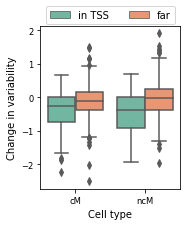

In [177]:
plt.figure(figsize=(2.5, 3))
sns.boxplot(x='ct', y='dv_coef', hue='distance_bin', data=ht_result_1d_all.query('(ct == "cM" | ct == "ncM") & de_coef > 0 & de_fdr < 0.05'), palette='Set2')

plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
# plt.ylim(-.8, 0.6)
plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')



### Filter for upregulated genes

In [192]:
ht_result_1d_dict.keys()

dict_keys(['CD4 T cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells', 'CD8 T cells', 'B cells'])

In [193]:
np.log(2)

0.6931471805599453

In [201]:
upreg_dict = {}
for ct in cts:
    
    upreg_dict[ct] = ht_result_1d_dict[ct].query('de_coef > 0 & de_fdr < 0.1').copy()
    upreg_dict[ct]['dv_fdr'] = schypo.util._fdrcorrect(upreg_dict[ct]['dv_pval'])
upreg_all = pd.concat([df for ct, df in upreg_dict.items()])

In [203]:
upreg_all.query('dv_coef < 0 & dv_fdr < 0.1').gene.drop_duplicates().shape

(65,)

In [ ]:
for gene in upreg_all.query('dv_coef < 0 & dv_fdr < 0.1').gene:
    print(gene)

### Format enrichment tables

In [211]:
table1 = pd.read_csv('upreg_dec_var_enrichr.txt', sep='\t')
table2 = pd.read_csv('upreg_inc_var_enrichr.txt', sep='\t')
table3 = pd.read_csv('stat1_dc_enrichr.txt', sep='\t')

In [212]:
table1[['Term', 'Overlap', 'P-value', 'Adjusted P-value']].sort_values('Adjusted P-value').head(10).to_csv('table1.csv', index=False)
table2[['Term', 'Overlap', 'P-value', 'Adjusted P-value']].sort_values('Adjusted P-value').head(10).to_csv('table2.csv', index=False)
table3[['Term', 'Overlap', 'P-value', 'Adjusted P-value']].sort_values('Adjusted P-value').head(10).to_csv('table3.csv', index=False)

### Get some numbers

In [196]:
ht_result_1d_all.query('de_fdr < 0.05').gene.drop_duplicates().shape

(1566,)

In [197]:
ht_result_1d_all.query('dv_fdr < 0.1').gene.drop_duplicates().shape

(129,)

In [198]:
ht_result_1d_all.query('de_coef > 0 & dv_coef < 0 & de_fdr < 0.05 & dv_fdr < 0.1').gene.drop_duplicates().shape

(58,)

In [199]:
ht_result_1d_all.query('de_coef > 0 & dv_coef > 0 & de_fdr < 0.05 & dv_fdr < 0.1').gene.drop_duplicates().shape

(12,)

In [200]:
ht_result_1d_all.query('de_coef > 0 & dv_coef > 0 & de_fdr < 0.05 & dv_fdr < 0.1').gene.drop_duplicates()#.shape

1189    MYL12A  
1036    B2M     
1150    CCR7    
622     SAT1    
860     BLOC1S2 
1106    FAM177A1
1013    DDIT3   
644     SRI     
806     TXN     
514     SERPINB1
602     SOD2    
564     MALAT1  
Name: gene, dtype: object

In [66]:
set(ht_result_1d_all.query('de_coef > 0 & dv_coef < 0 & de_fdr < 0.05 & dv_fdr < 0.1').gene.tolist()) & set(isgf3_genes)

NameError: name 'isgf3_genes' is not defined

In [67]:
len(set(ht_result_1d_all.gene.tolist()) & set(isgf3_genes))

NameError: name 'isgf3_genes' is not defined

In [68]:
len(isgf3_genes)

NameError: name 'isgf3_genes' is not defined

### DE effect size vs DV effect size by cell type

In [102]:
import schypo.util as util

In [103]:
def plot_de_dv(ct, result_df):
    
    de_diff = result_df['de_coef']
    dv_diff = result_df['dv_coef']
    de_fdr = result_df['de_fdr']
    dv_fdr = result_df['dv_fdr']
    
    plt.plot([0, 0], [np.nanmin(dv_diff), np.nanmax(dv_diff)], '--', lw=2, color='k')
    plt.plot([np.nanmin(de_diff), np.nanmax(de_diff)], [0, 0], '--', lw=2, color='k')
    
    de_sig = de_fdr < 0.05
    dv_sig = (dv_fdr < 0.1)
    dv_inc = dv_diff > 0
    dv_dec = dv_diff < 0
    
#     both_sig = de_sig & dv_sig

    plt.scatter(de_diff, dv_diff, s=1, color='grey', zorder=-1)
#     plt.scatter(de_diff[de_sig], dv_diff[de_sig], s=1, color='b')
    plt.scatter(de_diff[dv_sig & dv_inc], dv_diff[dv_sig & dv_inc], s=10, color='c', zorder=10)
    plt.scatter(de_diff[dv_sig & dv_dec], dv_diff[dv_sig & dv_dec], s=10, color='m', zorder=10)

#     plt.scatter(de_diff[both_sig], dv_diff[both_sig], s=1, color='m')
#     plt.xlim(-0.1, .1);
#     plt.ylim(-0.5, 0.3)
        
    plt.xlabel('$\Delta$Mean')
    if ct in ['NK cells', 'CD4 T cells']:
        plt.ylabel('$\Delta$Variability')
    
    print(ct, util.robust_correlation(de_diff[de_sig & dv_sig], dv_diff[de_sig & dv_sig]))

    plt.title(label_converter[ct])
#     plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
#     plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.255))

In [104]:
ht_result_1d_dict['CD4 T cells'].shape#.query('gene == "ISG15"')#.query('dv_fdr < 0.1')

(1367, 10)

CD4 T cells SpearmanrResult(correlation=0.07878787878787878, pvalue=0.8287173946974606)
CD14+ Monocytes SpearmanrResult(correlation=-0.7732851341098762, pvalue=1.0539357282794211e-20)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.8645320197044333, pvalue=1.4894066495214678e-09)


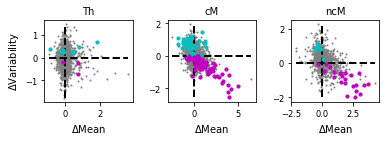

In [105]:
plt.figure(figsize=(6, 1.5))
plt.subplots_adjust(hspace=0.45, wspace=0.4)
for idx, ct in enumerate(cts[:3]):
    plt.subplot(1, 3, idx+1)
    plot_de_dv(ct, ht_result_1d_dict[ct])
# plt.savefig(fig_path + 'de_vs_dv.png', bbox_inches='tight', dpi=1200)
    

CD4 T cells SpearmanrResult(correlation=-0.0076612903225806465, pvalue=0.9673725521808867)
CD14+ Monocytes SpearmanrResult(correlation=-0.5583236062708643, pvalue=5.224335699800885e-13)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.6718824087245139, pvalue=5.282384667310449e-06)


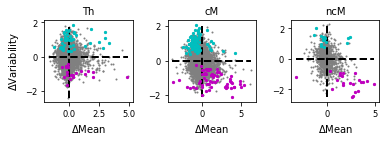

In [125]:
plt.figure(figsize=(6, 1.5))
plt.subplots_adjust(hspace=0.45, wspace=0.4)
for idx, ct in enumerate(cts[:3]):
    plt.subplot(1, 3, idx+1)
    plot_de_dv(ct, ht_result_1d_dict[ct])
plt.savefig(fig_path + 'de_vs_dv.png', bbox_inches='tight', dpi=1200)
    

### Single gene example

In [72]:
def plot_bar_strip(gene, ct_to_include=None):
    
    ct_list = cts if ct_to_include is None else ct_to_include
    expr_df_list = []
    for ct in ct_list:
        if gene in adata_dict[ct].var.index:
            gene_idx = adata_dict[ct].var.index.tolist().index(gene)
            for group in adata_dict[ct].uns['schypo']['groups']:
                expr_df_list.append((label_converter[ct], group.split('^')[0], group.split('^')[1], np.log(adata_dict[ct].uns['schypo']['1d_moments'][group][0][gene_idx]), np.log(adata_dict[ct].uns['schypo']['1d_moments'][group][2][gene_idx])))
    expr_df = pd.DataFrame(expr_df_list, columns=['ct','ind', 'stim', 'mean', 'variability'])

#     plt.figure(figsize=(3, 3))
    plt.subplots_adjust(hspace=0.1)

    plt.subplot(2, 1, 1)
    plt.title('{} expression in response to IFN-B'.format(gene))

    ax = sns.boxplot(x='ct', y='mean', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='mean', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks([]); plt.xlabel('')
    
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

    plt.subplot(2, 1, 2)
    ax = sns.boxplot(x='ct', y='variability', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='variability', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


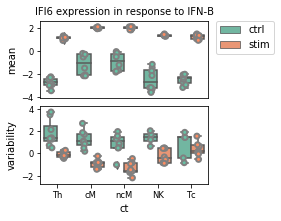

In [58]:
plot_bar_strip('IFI6', ct_to_include=None)
# plt.ylim(-1)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('IFI6'), bbox_inches='tight')

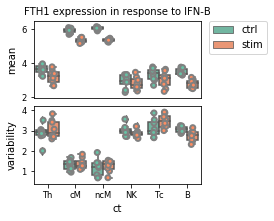

In [257]:
plot_bar_strip('FTH1', ct_to_include=None)
# plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

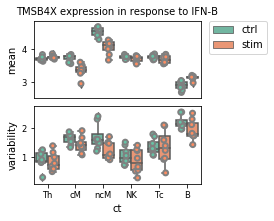

In [256]:
plot_bar_strip('TMSB4X', ct_to_include=None)
# plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


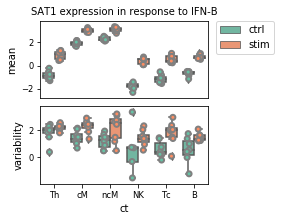

In [59]:
plot_bar_strip('SAT1', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

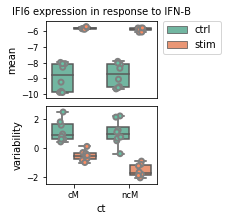

In [74]:
plt.figure(figsize=(2, 3))
plot_bar_strip('IFI6', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
# plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1_mono'), bbox_inches='tight')

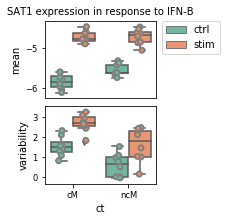

In [796]:
plt.figure(figsize=(2, 3))
plot_bar_strip('SAT1', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1_mono'), bbox_inches='tight')

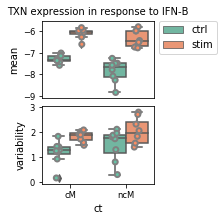

In [832]:
plt.figure(figsize=(2, 3))
plot_bar_strip('TXN', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('TXN_mono'), bbox_inches='tight')

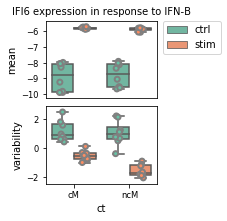

In [795]:
plt.figure(figsize=(2, 3))
plot_bar_strip('IFI6', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('IFI6_mono'), bbox_inches='tight')


### P-value calibrations

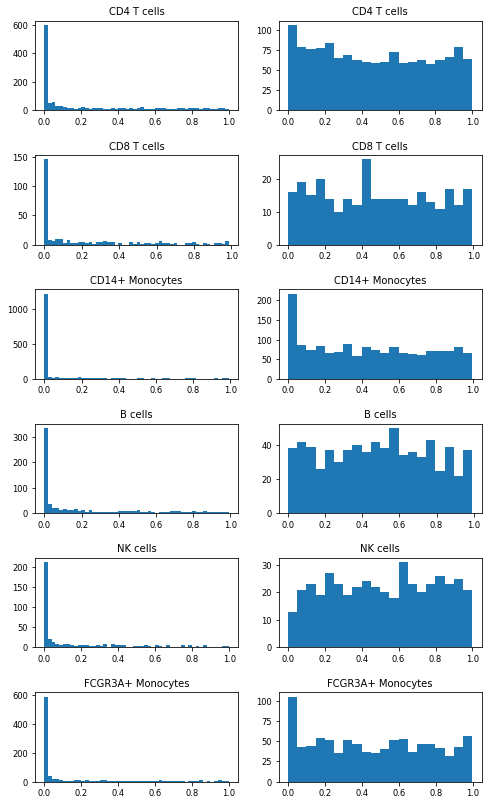

In [48]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'FCGR3A+ Monocytes']):
    
    plt.subplot(6, 2, 2*idx+1);
    plt.hist(adata_dict[ct].uns['schypo']['1d_ht']['mean_asl'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(6, 2, 2*idx+2);
    plt.hist(adata_dict[ct].uns['schypo']['1d_ht']['var_asl'], bins=20);
    plt.title('{}'.format(ct))
# plt.savefig(fig_path + 'de_dv_calibration.pdf', bbox_inches='tight')

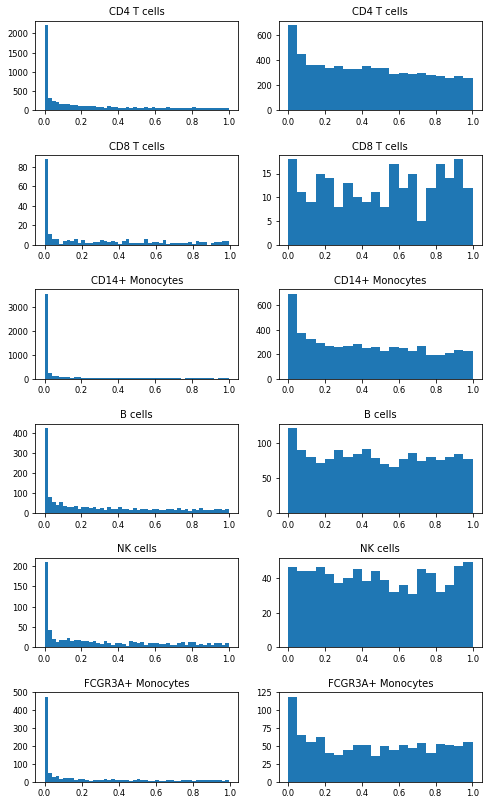

In [323]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'FCGR3A+ Monocytes']):
    
    plt.subplot(6, 2, 2*idx+1);
    plt.hist(adata_dict[ct].uns['schypo']['1d_ht']['mean_asl'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(6, 2, 2*idx+2);
    plt.hist(adata_dict[ct].uns['schypo']['1d_ht']['var_asl'], bins=20);
    plt.title('{}'.format(ct))
# plt.savefig(fig_path + 'de_dv_calibration.pdf', bbox_inches='tight')

### tSNE visualizations

In [126]:
ct = 'CD14+ Monocytes'

In [127]:
norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)


schypo.create_groups(temp_adata, label_columns=['stim'], inplace=True, q=0.07)
schypo.compute_1d_moments(
    temp_adata, 
    inplace=True, 
    filter_genes=True,
    filter_mean_thresh=0.07, 
    min_perc_group=.7)
print('Number of genes kept for {}: {}'.format(ct, temp_adata.shape[1]))


NameError: name 'temp_adata' is not defined

In [354]:
dv_genes = ht_result_1d_dict[ct].query('dv_fdr < 0.1').gene.tolist()
de_genes = ht_result_1d_dict[ct].query('de_fdr < 0.05').gene.tolist()

In [798]:
df = temp_adata.var.copy()
df['res_var'] = temp_adata.uns['schypo']['1d_moments']['sg^stim'][2]
df['mean'] = temp_adata.uns['schypo']['1d_moments']['sg^stim'][0]
df['gene'] = df.index.tolist()
df = df.merge( ht_result_1d_dict[ct], on='gene', how='left')
df = df[['gene','mean', 'de_coef', 'de_fdr', 'dv_coef', 'dv_fdr', 'distance']].copy()

In [799]:
df.columns

Index(['gene', 'mean', 'de_coef', 'de_fdr', 'dv_coef', 'dv_fdr', 'distance'], dtype='object')

In [814]:
df.sort_values('mean', ascending=False).query('dv_fdr < 0.1 & de_coef > 0').head(20)

,gene,mean,de_coef,de_fdr,dv_coef,dv_fdr,distance
0,ISG15,0.053311,4.849958,0.000007,-1.381630,0.009847,0.0
1527,CCL2,0.018918,1.539876,0.000007,-0.843775,0.000292,779924.0
1831,APOBEC3A,0.009533,3.731380,0.000004,-0.877491,0.006780,1319.0
811,SAT1,0.009400,1.099952,0.000007,1.160220,0.002433,9284.0
1421,ISG20,0.008701,3.588156,0.000004,-1.198426,0.001513,0.0
1039,IFITM3,0.007001,3.708360,0.000004,-1.604233,0.003877,0.0
217,RSAD2,0.004547,4.979162,0.000010,-1.553954,0.004650,0.0
1020,IFIT3,0.004432,4.928145,0.000004,-1.205761,0.062194,0.0
876,IDO1,0.004197,4.111858,0.000012,-1.512349,0.004200,1518982.0
915,LY6E,0.003880,3.828250,0.000004,-2.112450,0.002903,1558.0


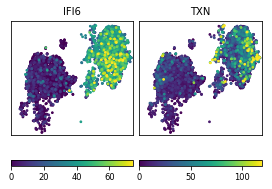

In [820]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'IFI6', 'TXN'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
plt.savefig(fig_path + 'TXN_IFI6_variability.png', bbox_inches='tight')

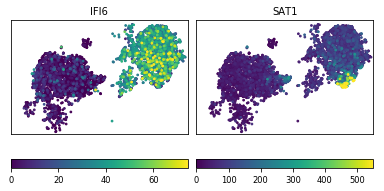

In [133]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'IFI6', 'SAT1'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(6.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
plt.savefig(fig_path + 'SAT1_IFI6_variability.png', bbox_inches='tight', dpi=1200)

In [303]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)

             gene_ids     mt     hb  n_cells_by_counts  mean_counts  \
626   ENSG00000204525  False  False  23534              5.866129      
1528  ENSG00000108688  False  False  2148               1.198841      

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
626   1.92660            4.616382               144735.0       
1528  0.78793            91.294127              29579.0        

      log1p_total_counts    res_var  ...   gene   de_coef       de_pval  \
626   11.882667           0.427133   ...  HLA-C  0.438640  5.660027e-07   
1528  10.294854           16.452070  ...  CCL7   2.237434  3.190720e-07   

       dv_coef  dv_pval    de_fdr    dv_fdr  isgf3_binding gene_type  ct  
626  -0.470037  0.39776  0.000003  0.772670  False          upreg     cM  
1528 -0.656460  0.00048  0.000002  0.013082  False          upreg     cM  

[2 rows x 21 columns]


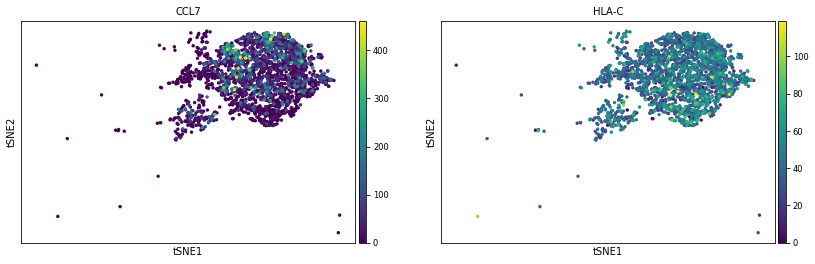

In [314]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'CCL7', 'HLA-C'
print(df[df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

In [129]:
def variability_scatter(X, c, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
def expr_violin(adata, gene_1, gene_2):
    
    df_1 = pd.DataFrame()
    df_1['expr'] = adata[:, gene_1].X.toarray().ravel()
    df_1['gene'] = gene_1
    
    df_2 = pd.DataFrame()
    df_2['expr'] = adata[:, gene_2].X.toarray().ravel()
    df_2['gene'] = gene_2
    
    sns.violinplot(x='gene', y='expr', data=pd.concat([df_1, df_2]))
    
    

In [187]:
list(plt.cm.get_cmap('tab10'))

TypeError: 'ListedColormap' object is not iterable

In [188]:
cmap = plt.cm.get_cmap('tab10')
cmap2 = plt.cm.get_cmap('Set3')

In [191]:
cmap_master = [cmap(i) for i in range(10)] + [cmap2(i) for i in range(10)]

In [214]:
cmap_master = ['cornflowerblue','tab:orange','tab:green','tab:red','blueviolet',
               'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan',
              'lightcoral','gold','lightgreen','deeppink','dodgerblue',
              'tab:blue','tab:purple']

In [215]:
len(cmap_master)

17

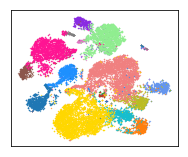

In [248]:
plt.figure(figsize=(3, 2.5))
for i,group in enumerate(adata.obs.cell_type.sort_values(ascending=False).drop_duplicates()):
    
    temp = adata[adata.obs.cell_type == group]
    plt.scatter(temp.obsm['X_tsne'][:, 0],temp.obsm['X_tsne'][:, 1], c=cmap_master[i], s=0.1, alpha=1)
    plt.xticks([]);plt.yticks([])
plt.savefig(fig_path + 'all_ct_tsne.png', bbox_inches='tight')

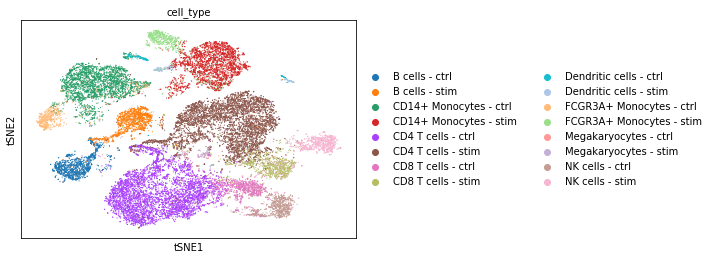

In [240]:
sc.pl.tsne(adata, color='cell_type')

Text(0.5, 1.0, 'APOBEC3A')

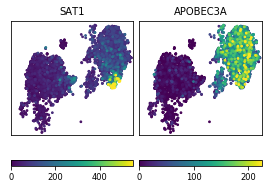

In [283]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'SAT1', 'APOBEC3A'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
# plt.savefig(fig_path + 'SAT1_APOBEC3A_variability.png', bbox_inches='tight')

In [344]:
df.columns

Index(['gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'res_var', 'mean', 'gene', 'de_coef', 'de_pval',
       'dv_coef', 'dv_pval', 'de_fdr', 'dv_fdr', 'isgf3_binding', 'gene_type',
       'ct'],
      dtype='object')

           mean   de_coef        de_fdr   dv_coef    dv_fdr
811   20.023121  1.099953  3.214645e-06  0.814596  0.012093
1831  20.346989  3.731380  9.176641e-07 -1.527488  0.000225


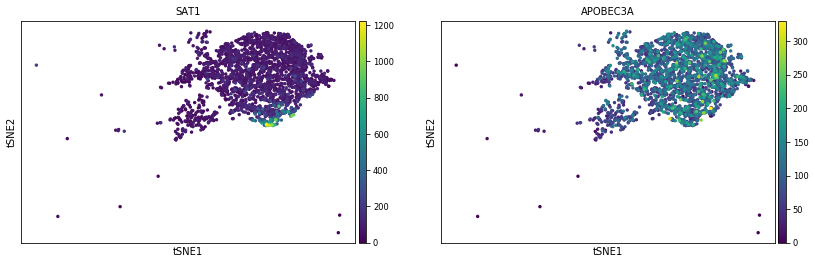

In [345]:

ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'SAT1', 'APOBEC3A'
print(df[['mean', 'de_coef', 'de_fdr', 'dv_coef', 'dv_fdr']][df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

            gene_ids     mt     hb  n_cells_by_counts  mean_counts  \
99   ENSG00000162645  False  False  7840               0.498521      
469  ENSG00000163734  False  False  1665               0.330929      

     log1p_mean_counts  pct_dropout_by_counts  total_counts  \
99   0.404478           68.224375              12300.0        
469  0.285877           93.251733              8165.0         

     log1p_total_counts    res_var  ...   gene   de_coef       de_pval  \
99   9.417436            0.697276   ...  GBP2   0.866642  3.944090e-06   
469  9.007734            19.588949  ...  CXCL3 -1.247853  4.603380e-07   

      dv_coef   dv_pval    de_fdr    dv_fdr  isgf3_binding gene_type  ct  
99  -0.220630  0.007400  0.000009  0.100839  False          upreg     cM  
469  0.081091  0.540546  0.000003  0.833955  False          upreg     cM  

[2 rows x 21 columns]


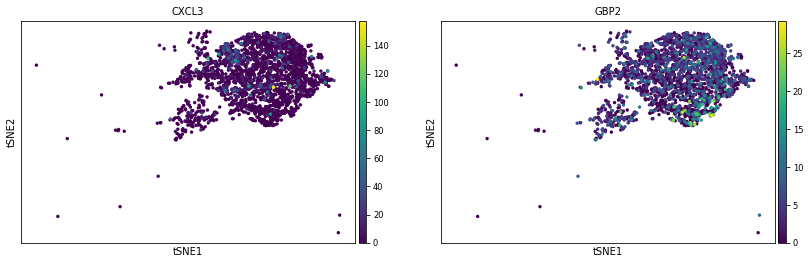

In [311]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'CXCL3', 'GBP2'
print(df[df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

### Calibration

In [196]:
%%time

ct = 'NK cells'
print('Processing:', ct)
adata_test = adata[adata.obs.cell == ct].copy()


# adata_test.obs['stim'] = np.random.choice(adata_test.obs['stim'], adata_test.shape[0])
schypo.create_groups(adata_test, label_columns=['stim', 'ind'], inplace=True, q=0.07)
schypo.compute_1d_moments(
    adata_test, 
    inplace=True, 
    filter_genes=True,
    filter_mean_thresh=0.0, 
    min_perc_group=.9)
print('Number of genes kept for {}: {}'.format(ct, adata_test.shape[1]))
schypo.ht_1d_moments(
    adata_test, 
    formula_like='1 + stim',
    cov_column='stim', 
    num_boot=5000, 
    verbose=1,
    num_cpus=6)

Processing: NK cells
Number of genes kept for NK cells: 816


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   15.2s


CPU times: user 4.99 s, sys: 164 ms, total: 5.15 s
Wall time: 35.7 s


[Parallel(n_jobs=6)]: Done 816 out of 816 | elapsed:   34.8s finished


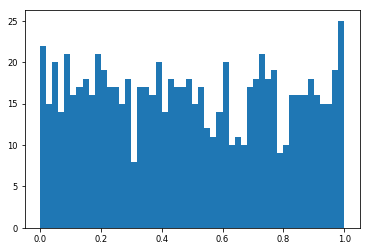

In [197]:
plt.hist(adata_test.uns['schypo']['1d_ht']['var_asl'], bins=50);

In [198]:
df = schypo.get_1d_ht_result(adata_test)
df['dv_fdr'] = util._fdrcorrect(df['dv_pval'])

In [199]:
df.query('gene == "SAT1"')

,gene,de_coef,de_pval,dv_coef,dv_pval,dv_fdr


In [200]:
df.query('dv_fdr < 0.1')

,gene,de_coef,de_pval,dv_coef,dv_pval,dv_fdr
211,CDKN2AIP,-0.001883,0.812238,-1.638334,0.000080,0.058006
219,GZMK,1.246177,0.000187,1.860377,0.000142,0.058006
